In [21]:
from NPHM.models.deepSDF import DeepSDF, DeformationNetwork
from NPHM.models.EnsembledDeepSDF import FastEnsembleDeepSDFMirrored
from NPHM import env_paths
from NPHM.utils.reconstruction import create_grid_points_from_bounds, mesh_from_logits
from NPHM.models.reconstruction import deform_mesh, get_logits, get_logits_backward
from NPHM.models.fitting import inference_iterative_root_finding_joint, inference_identity_space
from NPHM.data.manager import DataManager

import numpy as np
import argparse
import json, yaml
import os
import os.path as osp
import torch
import pyvista as pv
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
# load general config
with open('scripts/configs/fitting_nphm.yaml', 'r') as f:
    print('Loading config file from: ' + 'scripts/configs/fitting_nphm.yaml')
    CFG = yaml.safe_load(f)
print(json.dumps(CFG, sort_keys=True, indent=4))

# paths to shape and expression MLP config
weight_dir_shape = env_paths.EXPERIMENT_DIR + '/{}/'.format(CFG['exp_name_shape'])
weight_dir_expr = env_paths.EXPERIMENT_DIR + '/{}/'.format(CFG['exp_name_expr'])

# load shape and expression MLP config
fname_shape = weight_dir_shape + 'configs.yaml'
with open(fname_shape, 'r') as f:
    print('Loading config file from: ' + fname_shape)
    CFG_shape = yaml.safe_load(f)
fname_expr = weight_dir_expr + 'configs.yaml'
with open(fname_expr, 'r') as f:
    print('Loading config file from: ' + fname_expr)
    CFG_expr = yaml.safe_load(f)

Loading config file from: scripts/configs/fitting_nphm.yaml
{
    "checkpoint_expr": 2500,
    "checkpoint_shape": 15000,
    "exp_name_expr": "nphm_expression_space_pretrained",
    "exp_name_shape": "nphm_identity_space_pretrained",
    "lambdas_shape": {
        "reg_global": 0.002,
        "reg_unobserved": "5.0 0",
        "reg_zero": 0.005,
        "surface": 2.0,
        "symm_dist": 1.0
    },
    "local_expr": false,
    "local_shape": true,
    "mode": "compress"
}
Loading config file from: /Users/katharinaschmid/Text2Head/NPHM-main/katha//nphm_identity_space_pretrained/configs.yaml
Loading config file from: /Users/katharinaschmid/Text2Head/NPHM-main/katha//nphm_expression_space_pretrained/configs.yaml


In [6]:
device = torch.device("cpu")

In [7]:
# Print shape MLP config
print('###########################################################################')
print('####################     Shape Model Configs     #############################')
print('###########################################################################')
print(json.dumps(CFG_shape, sort_keys=True, indent=4))

# Print expression MLP config
print('###########################################################################')
print('####################     Expression Model Configs     #############################')
print('###########################################################################')
print(json.dumps(CFG_expr, sort_keys=True, indent=4))

# Load anchor points
lm_inds = np.load(env_paths.ANCHOR_INDICES_PATH)
anchors = torch.from_numpy(np.load(env_paths.ANCHOR_MEAN_PATH)).float().unsqueeze(0).unsqueeze(0).to(device)

###########################################################################
####################     Shape Model Configs     #############################
###########################################################################
{
    "anchors_path": "/cluster/daidalos/sgiebenhain/anchors_39.npy",
    "data": {
        "n_expressions": 1,
        "n_subjects": 300,
        "root": "/cluster/angmar/sgiebenhain/synth_data_2neutral"
    },
    "decoder": {
        "decoder_hidden_dim": 200,
        "decoder_lat_dim_glob": 64,
        "decoder_lat_dim_loc": 32,
        "decoder_nlayers": 4,
        "decoder_nloc": 39,
        "decoder_nsymm_pairs": 16,
        "dropout": false,
        "type": "deep_sdf_decoder",
        "weight_norm": false
    },
    "encoder": null,
    "lm_inds_path": "/cluster/daidalos/sgiebenhain/lm_inds_39.npy",
    "training": {
        "batch_size": 32,
        "ckpt_interval": 500,
        "grad_clip": 0.1,
        "grad_clip_lat": 0.1,
        "lambdas": {
   

In [17]:
# Initialize Shape MLP using CFG
decoder_shape = FastEnsembleDeepSDFMirrored(
        lat_dim_glob=CFG_shape['decoder']['decoder_lat_dim_glob'],
        lat_dim_loc=CFG_shape['decoder']['decoder_lat_dim_loc'],
        hidden_dim=CFG_shape['decoder']['decoder_hidden_dim'],
        n_loc=CFG_shape['decoder']['decoder_nloc'],
        n_symm_pairs=CFG_shape['decoder']['decoder_nsymm_pairs'],
        anchors=anchors,
        n_layers=CFG_shape['decoder']['decoder_nlayers'],
        pos_mlp_dim=CFG_shape['decoder'].get('pos_mlp_dim', 256),
    )

decoder_shape = decoder_shape.to(device)

# Initialize Expression MLP using CFG
decoder_expr = DeformationNetwork(mode=CFG_expr['ex_decoder']['mode'],
                                 lat_dim_expr=CFG_expr['ex_decoder']['decoder_lat_dim_expr'],
                                 lat_dim_id=CFG_expr['ex_decoder']['decoder_lat_dim_id'],
                                 lat_dim_glob_shape=CFG_expr['id_decoder']['decoder_lat_dim_glob'],
                                 lat_dim_loc_shape=CFG_expr['id_decoder']['decoder_lat_dim_loc'],
                                 n_loc=CFG_expr['id_decoder']['decoder_nloc'],
                                 anchors=anchors,
                                 hidden_dim=CFG_expr['ex_decoder']['decoder_hidden_dim'],
                                 nlayers=CFG_expr['ex_decoder']['decoder_nlayers'],
                                 input_dim=3, out_dim=3
                                 )
decoder_expr = decoder_expr.to(device)

# Load shape MLP weights
path = osp.join(weight_dir_shape, 'checkpoints/checkpoint_epoch_{}.tar'.format(CFG['checkpoint_shape']))
print('Loaded checkpoint from: {}'.format(path))
checkpoint = torch.load(path, map_location=device)
decoder_shape.load_state_dict(checkpoint['decoder_state_dict'], strict=True)

if 'latent_codes_state_dict' in checkpoint:
    n_train_subjects = checkpoint['latent_codes_state_dict']['weight'].shape[0]
    n_val_subjects = checkpoint['latent_codes_val_state_dict']['weight'].shape[0]
    latent_codes_shape = torch.nn.Embedding(n_train_subjects, 512)
    latent_codes_shape_val = torch.nn.Embedding(n_val_subjects, 512)
    
    latent_codes_shape.load_state_dict(checkpoint['latent_codes_state_dict'])
    latent_codes_shape_val.load_state_dict(checkpoint['latent_codes_val_state_dict'])
else:
    print('no latent codes in state dict of shape decoder')
    latent_codes_shape = None
    latent_codes_shape_val = None

# Load expression MLP weights
path = osp.join(weight_dir_expr, 'checkpoints/checkpoint_epoch_{}.tar'.format(CFG['checkpoint_expr']))
print('Loaded checkpoint from: {}'.format(path))
checkpoint = torch.load(path, map_location=device)
decoder_expr.load_state_dict(checkpoint['decoder_state_dict'], strict=True)
if 'latent_codes_state_dict' in checkpoint:
    latent_codes_expr = torch.nn.Embedding(checkpoint['latent_codes_state_dict']['weight'].shape[0], 200)
    latent_codes_expr.load_state_dict(checkpoint['latent_codes_state_dict'])
    latent_codes_expr_val = torch.nn.Embedding(checkpoint['latent_codes_val_state_dict']['weight'].shape[0], 200)
    latent_codes_expr_val.load_state_dict(checkpoint['latent_codes_val_state_dict'])
else:
    print('no latent codes in state dict of exression decoder')
    latent_codes_expr = None
    latent_codes_expr_val = None

creating DeepSDF with...
lat dim 232
hidden_dim 512
235
512
Loaded checkpoint from: /Users/katharinaschmid/Text2Head/NPHM-main/katha//nphm_identity_space_pretrained/checkpoints/checkpoint_epoch_15000.tar
no latent codes in state dict of shape decoder
Loaded checkpoint from: /Users/katharinaschmid/Text2Head/NPHM-main/katha//nphm_expression_space_pretrained/checkpoints/checkpoint_epoch_2500.tar
no latent codes in state dict of exression decoder


In [18]:
# Get latent shape code statistics
lat_mean = torch.from_numpy(np.load(env_paths.ASSETS + 'nphm_lat_mean.npy'))
lat_std = torch.from_numpy(np.load(env_paths.ASSETS + 'nphm_lat_std.npy'))

# Sample a latent shape code
lat_rep_shape = (torch.randn(lat_mean.shape) * lat_std * 0.85 + lat_mean)
print(lat_rep_shape.shape) #40*32+64

# Set relevant part and resolution
mini = [-.55, -.5, -.95]
maxi = [0.55, 0.75, 0.4]
resolution = 35

# Define grid points (relevant for Marching Cubes only)
grid_points = create_grid_points_from_bounds(mini, maxi, resolution)
print(grid_points)
grid_points = torch.from_numpy(grid_points).to(device, dtype=torch.float)
grid_points = torch.reshape(grid_points, (1, len(grid_points), 3)).to(device)
print(grid_points.shape)

torch.Size([1344])
[[-0.55       -0.5        -0.95      ]
 [-0.55       -0.5        -0.91029412]
 [-0.55       -0.5        -0.87058824]
 ...
 [ 0.55        0.75        0.32058824]
 [ 0.55        0.75        0.36029412]
 [ 0.55        0.75        0.4       ]]
torch.Size([1, 42875, 3])


starting mcubes
done mcubes


/opt/anaconda3/envs/NPHM/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


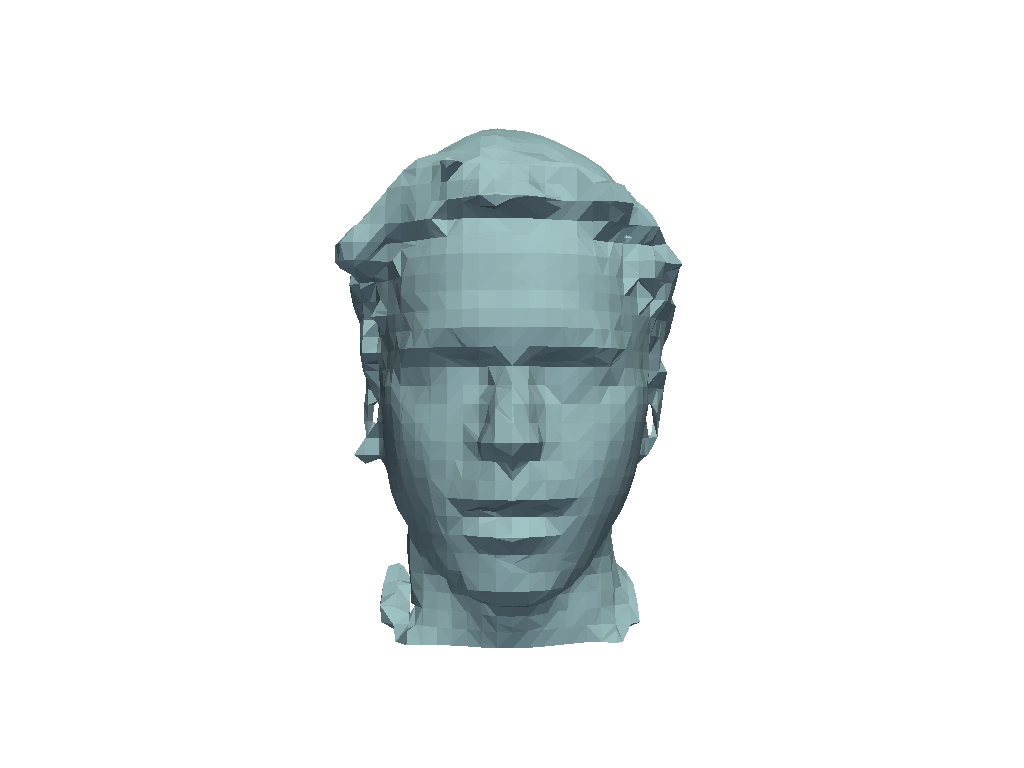

vtkOpenGLCamera (0x7fe4b4a2ccc0)
  Debug: Off
  Modified Time: 9522
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (2.16884, 4.33389)
  DirectionOfProjection: (-0.000234167, 0.0189923, -0.99982)
  Distance: 3.124
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (-0.00073946, 0.0599745, -0.157261)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 0.808551
  Position: (-7.92169e-06, 0.000642496, 2.96618)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.16505
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (0.000234167, -0.0189923, 0.99982)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600003929e00
    Debug: Off
    Modified Time: 7485
    Reference Count: 1
    Registered Events: (none)
  

In [19]:
# Get SDF values for all grid points
logits = get_logits(decoder_shape, lat_rep_shape, grid_points, nbatch_points=100)

print('starting mcubes')
mesh = mesh_from_logits(logits, mini, maxi, resolution)
print('done mcubes')

pl = pv.Plotter(off_screen=True)
pl.add_mesh(mesh)
pl.reset_camera()
pl.camera.position = (0, 0, 3)
pl.camera.zoom(1.4)
pl.set_viewup((0, 1, 0)) #vertical direction of camera = +Y axis
pl.camera.view_plane_normal = (-0, -0, 1) #camera is looking at XY plane
pl.show()
#pl.show(screenshot=out_dir + '/step_{:04d}.png'.format(step))
#mesh.export(out_dir + '/mesh_{:04d}.ply'.format(step))
print(pl.camera)

Um die Expressions zu berücksichtigen, benötigen wir:
1. latent expression code (dim=200) --> How to sample? 
2. low-dimensional version of the latent identity code (dim=??) --> Is this automatically computed by DeepSDF or do we need to sample it (and how)?

In [20]:
#TODO: How to include expressions?
#lat_rep_expr = ??
#lat_rep_shape_ex = ??
#deformed_mesh = deform_mesh(mesh,
#                decoder_expr,
#                lat_rep_expr,
#                anchors,
#                lat_rep_shape_ex)

In [25]:
#TODO: Improve rendering performance
#TODO: Save output images of different identities
# Define rendering parameters
res = 80
camera_position = torch.tensor([0.0, 0.0, 3.0])
max_ray_length = 4 - 2.3

# Define phong model constants
ambient_coeff = 0.1
diffuse_coeff = 0.6
specular_coeff = 0.3
shininess = 32.0

# Define light inputs
light_position = torch.tensor([2.0, 1.0, 3.0])

# Create an empty image
image = torch.zeros((res, res, 3))
#image = 0.01 * torch.ones((res, res, 3))

def phong_model(normal, light_dir, view_dir):
    # Normalize all vectors
    normal = normal / torch.norm(normal, dim=-1)
    light_dir = light_dir / torch.norm(light_dir, dim=-1)
    view_dir = view_dir / torch.norm(view_dir, dim=-1)
    
    ambient = ambient_coeff
    diffuse = diffuse_coeff * torch.clamp(torch.sum(light_dir * normal, dim=-1), min=0.0)
    reflect_dir = light_dir - 2 * normal * torch.clamp(torch.sum(light_dir * normal, dim=-1), min=0.0)
    specular = specular_coeff * torch.pow(torch.clamp(torch.sum(reflect_dir * view_dir, dim=-1), min=0.0), shininess)

    return ambient + diffuse + specular

def estimate_normal(sdf, point, epsilon=1e-3):
    # Calculate the SDF value at the given point
    sdf_value = sdf(point)

    # Calculate SDF values at neighboring points
    sdf_dx = sdf(point + torch.tensor([epsilon, 0, 0]))
    sdf_dy = sdf(point + torch.tensor([0, epsilon, 0]))
    sdf_dz = sdf(point + torch.tensor([0, 0, epsilon]))

    # Calculate the gradient using finite differences
    gradient = torch.tensor([sdf_dx - sdf_value, sdf_dy - sdf_value, sdf_dz - sdf_value])

    # Normalize the gradient to obtain the estimated normal
    normal = gradient / torch.norm(gradient, p=2)
    
    return normal

def sdf_sphere(position, radius=0.75):
    return torch.norm(position, dim=-1) - radius

def sdf_nphm(position):
    position = position.unsqueeze(0).unsqueeze(0) # [1, N, 3], lat_rep [lat_dim]
    distance, _ = decoder_shape(position, lat_rep.repeat(1, position.shape[1], 1), None)
    return distance

def ray_march(camera_position, direction, max_length):
    position = camera_position + 2.3 * direction
    step_size = 0.01

    for _ in range(int(max_length / step_size)):
        distance = sdf_sphere(position)  # Replace with your SDF function
        #distance = sdf_nphm(position)
        if distance < 0.01:
            return position  # Ray hits the surface

        position += step_size * direction

    return None  # Ray misses the scene

# Rendering loop
for v in range(res):
    for u in range(res):
        # Normalize the xy value of the current pixel [-1, 1]
        u_norm = (2.0 * (u + 0.5) / res - 1.0)
        v_norm = 1.0 - 2.0 * (v + 0.5) / res
        u_norm = torch.tensor([u_norm])
        v_norm = torch.tensor([v_norm])
         # Calculate the ray direction for the current pixel
        direction_unn = torch.tensor([u_norm, v_norm, -3.0])
        direction = direction_unn / torch.norm(direction_unn, dim=-1)

        # Perform ray marching
        hit_position = ray_march(camera_position, direction, max_ray_length)

        # Color the pixel based on whether the ray hits an object
        if hit_position is not None:
            normal = estimate_normal(sdf_sphere, hit_position)
            light_dir = - (hit_position - light_position) # umdrehen, damit L*V >0
            view_dir = - (camera_position - hit_position) # umdrehen, damit dot product nicht kleienr null?
            reflection = phong_model(normal, light_dir, view_dir)
            # Assign a color for objects
            image[v, u] = reflection * torch.tensor([1.0, 1.0, 1.0])


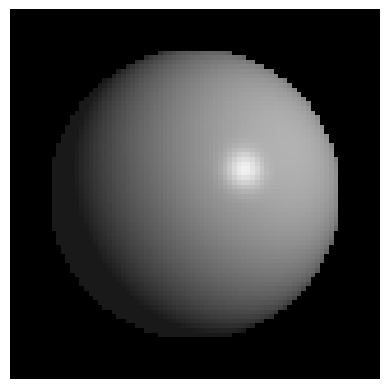

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [26]:
# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axes
plt.show()
print(image[:, :, 0])

In [27]:
# Save image
image = (image * 255).byte()  # Convert to a byte tensor (0-255)
image_np = image.cpu().numpy()  # Convert to a NumPy array
image_pil = Image.fromarray(image_np)

# Save the image to a specific folder with a desired filename
output_folder = '/Users/katharinaschmid/Text2Head/NPHM-main/rendering_data/'
output_filename = 'output_image.png'
image_pil.save(os.path.join(output_folder, output_filename))